# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

## Preprocessing
We will be utilizing mostly KNN and tree-based algorithms. We will first turn categorical features to binary dummies.

In [4]:
# Turning all categorical features to dummies 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [5]:
# Check if training and testing sets have the same features
if X_train_ohe.shape[1] != X_test_ohe.shape[1]:
    print([x for x in X_train_ohe.columns if x not in X_test_ohe.columns])
    print([x for x in X_test_ohe.columns if x not in X_train_ohe.columns])
else: 
    print ('Good to go')

Good to go


In [6]:
# If they are not the same, add the column with 0s and fix the order
# X_test_ohe[colname] = 0
# X_test_ohe = X_test_ohe[X_train_ohe.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, but in some cases where imbalance weight is not adequately dealt with by algorithm we test with resampled set using SMOTE.

In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_sample(X_train_ohe, y_train)

## Evaluation Metrics
Our target is multi-class with imbalance issue. To focus on the imbalance of minority classes, we will use balanced accuracy score as our primary metrics. This computes the average accuracy score weighted by the inverse prevalence of the true classes. Additionally we will also look at the weighted f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average weighted by the number of actual positive cases in each class, so naturally penalizes if minority recall is low.

In terms of prediction of each class, we rather want to overpredict 'needs repair'(minority) case than the functional cases. Because the consistent health of the well is crucial for survival of surrounding population. Specifically, we want the sensitivy of the repair cases to be high because false positive of minority classes is better than missing those actually needing repairs. I will look at this breakdown using the classification report.

In [7]:
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_confusion_matrix, classification_report

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [9]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test_ohe)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)

Test F1 score:  0.444 / Test Accuracy:  0.336


                         precision    recall  f1-score   support

             functional       0.54      0.53      0.54      4822
functional needs repair       0.09      0.08      0.08       678
         non functional       0.38      0.39      0.39      3410

               accuracy                           0.44      8910
              macro avg       0.34      0.34      0.34      8910
           weighted avg       0.44      0.44      0.44      8910



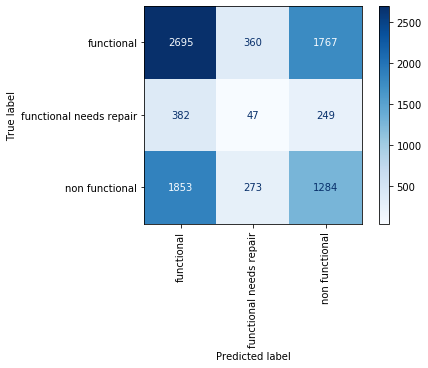

In [10]:
plot_confusion_matrix(dummyc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 and less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.

## kNearestNeighbors
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For kNN, all feature values need to be standardized.

In [8]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

X_train_res_scaled = scale.fit_transform(X_train_res)

### Scoring Function
Function to return weighted F1 and balanced accuracy score

In [9]:
def scoring(y_test, y_pred):
    f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
    acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
    print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)

### kNN with GridSearchCV

Finding the optimal value for K using GridSearchCV.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'balanced_accuracy', verbose = 1, n_jobs = -1)
knc_g.fit(X_train_scaled, y_train)
#print(knc_g.best_params_, ': ', knc_g.best_score_)

In [ ]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test_scaled)    
scoring(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Test F1 score:  0.741 / Test Accuracy:  0.622
# Recall for functional needs repair: 0.32

In [ ]:
y_train_pred = knc_g.predict(X_train_scaled)    
f1_test = round(f1_score(y_train, y_train_pred, average = 'weighted'), 3)
f1_test
# 0.998

Overall improvement from the dummy model, but the recall of needs repair class is still low. Looking at training score (.99) shows that it's highly overfitting. In this document we'll see if different optimization method finds a better hyperparameter.  

*Future consideration - In 030B file under eunjoo branch, we explored more into limiting features using random forest feature selection for KNN as KNN does not select features and can make the model messy. As a summary, after Random Forest feature selection, the performance didn't improve, but also didn't drop. So we know for KNN those extra features could be unnecessarily complicating our model. For the sake of keeping it consistent with the rest of models, we will keep all features (they have been already selected based on intuition in the EDA notebook) for now. But we may consider dropping some of those features in the future.*

In [14]:
# saving the model 
#mod = open('PKL/knn_gsc.pkl', 'wb')
#pickle.dump(knc_g.best_estimator_, mod)
#mod.close()
# Reload the model
#knc_g = pickle.load(open('PKL/knn_gsc.pkl', 'rb'))

### kNN with Optuna
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to be same as the time it took to complete GridSearch above.

In [11]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

# initiating the optuna study
knn_study = optuna.create_study(direction='maximize')

# optimization process
knn_study.optimize(find_hyperp_KNN, timeout = 16*60)

In [20]:
# saving the study 
#mod = open('PKL/knn_study.pkl', 'wb')
#pickle.dump(knn_study, mod)
#mod.close()
# Reload the study
#knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [ ]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
scoring(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Test F1 score:  0.753 / Test Accuracy:  0.631
# functional needs repair recall = 0.32

Recall score for the needs repair class is still low but the overall performance and the recall for non-functional improved slightly.

In [61]:
# saving the model
#mod = open('PKL/knc_opt_model.pkl', 'wb')
#pickle.dump(knc_opt, mod)
#mod.close()

### SMOTE - kNN 
Since kNN consistently failed to improve recall score for the minority class, we'll try to run it with SMOTE resampled set.

#### Simple kNN
Running kNN with default parameters

In [ ]:
knnSimple = KNeighborsClassifier()
knnSimple.fit(X_train_res_scaled, y_train)
y_pred = knnSimple.predict(X_test_res_scaled)

scoring(y_test, y_pred)
# Test F1 score:  0.717 / Test Accuracy:  0.656
# needs repair recall = 0.54

Minority recall score has improved! let's try to optimize hyperparmeters.

In [ ]:
#mod = open('PKL/knnSimple.pkl', 'wb')
#pickle.dump(knnSimple, mod)
#mod.close()

#### kNN with Optuna

In [ ]:
def knn_objective(trial): 
    knn_neighbors = trial.suggest_int('n_neighbors', 1,10) 
    knn_p = trial.suggest_categorical('p', [1, 2])
    knn_leaf_size = trial.suggest_int('leaf_size', 2, 50)
    knn_algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors, 
                               p = knn_p, 
                               leaf_size = knn_leaf_size,
                               algorithm =  knn_algorithm)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_res_scaled, y_train_res, scoring = 'balanced_accuracy', 
                                    cv = cv, n_jobs = -1))
    return (score)

# initiating the optuna study
knn_optuna = optuna.create_study(direction='maximize')

# optimization process
knn_optuna.optimize(knn_objective, n_trials = 100)

In [ ]:
# Testing the best params on the test set
knnOptuna = KNeighborsClassifier(**knn_optuna.best_params)
knnOptuna.fit(X_train_res_scaled, y_train_res)

y_pred = knnOptuna.predict(X_test_res_scaled)    
scoring(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Test F1 score:  0.742 / Test Accuracy:  0.567
# functional needs repair recall = 0.46

Optuna hyperparameter did not improved our performance.

In [ ]:
# saving model
#mod = open('PKL/knnOptuna.pkl', 'wb')
#pickle.dump(knnOptuna, mod)
#mod.close()

## Simple Decision Trees
Since we have a lot of features, tree-based model might deal better by ignoring less important features. We will first try with a simple tree.

In [ ]:
dtcSimple = DecisionTreeClassifier(criterion = 'gini', 
                                   max_depth = 20, 
                                   class_weight = 'balanced')
dtcSimple.fit(X_train_res_scaled, y_train)
y_pred_dtcSimple = dtcSimple.predict(X_test_res_scaled)
scoring(y_test, y_pred)
# Test F1 score:  0.728 / Test Accuracy:  0.642
# functional needs repair recall = 0.45

About similar performance as kNN.

## Random Forest 
We will run random forest optimized by Optuna.

In [12]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [ ]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    #min_samples_split = trial.suggest_int('min_samples_split', 0, 10)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 100)
    rfc = RandomForestClassifier(oob_score = True, 
                             n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             #min_samples_split = min_samples_split, 
                             #min_samples_leaf = min_samples_leaf, 
                             criterion = criterion, 
                             class_weight = class_weight, 
                             max_features = max_features)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_ohe, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 60*60*3) # run it for 3 hours

In [ ]:
rf = RandomForestClassifier(oob_score = True, **rfc_study.best_params)

rf.fit(X_train_ohe, y_train)
y_pred = rf.predict(X_test_ohe)  
scoring(y_test, y_pred)
# Test F1 score:  0.731 / Test Accuracy:  0.694
# functional needs repair recall = 0.66

Much better performance in predicting the positive minority cases even though overall F1 score has dropped slightly. This model seems to be weighing the minority recall better. 

In [33]:
# save the study
#mod = open('PKL/rfc_study.pkl', 'wb')
#pickle.dump(rfc_study, mod)
#mod.close()
# Reload the study
#rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [62]:
# save the model
#mod = open('PKL/rf_model.pkl', 'wb')
#pickle.dump(rf, mod)
#mod.close()

## XGBoost
Now we'll try to run XGBoost with Optuna.

In [13]:
import xgboost as xgb

In [ ]:
def find_hyperparam(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 15)
    #min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             #min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_ohe, y_train, scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 60*60)

In [45]:
# fitting and testing on the test set

xgbc = xgb.XGBClassifier(**xgb_study.best_params, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_ohe, y_train)
y_pred = xgbc.predict(X_test_ohe)    
scoring(y_test, y_pred)
# Test F1 score:  0.802 / Test Accuracy:  0.664
# functional needs repair recall = 0.31

Test F1 score:  0.802 / Test Accuracy:  0.664


Top majority classes are doing so much better, but the minority class recall score dropped significantly from random forest model. We'll try to oversampling the minority classes and try again.

In [44]:
#Saving study
#mod = open('PKL/xgb_study.pkl', 'wb')
#pickle.dump(xgb_study, mod)
#mod.close()
# Reload the study
#xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [63]:
# saving model
#mod = open('PKL/xgbc_model.pkl', 'wb')
#pickle.dump(xgbc, mod)
#mod.close()

## SMOTE - XGBoost
In order to control for class imbalance in XGBoost, we'll use SMOTE resampled set.

In [65]:
# Optuna optimization
def find_hyperparam2(trial):
    
    eta = trial.suggest_loguniform("eta", 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform("subsample", 1e-8, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    max_delta_step = trial.suggest_int('max_delta_step', 0, 1)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                             num_parallel_tree = num_parallel_tree, 
                             max_delta_step = max_delta_step,
                             )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_res, y_train_res, 
                                    scoring = 'balanced_accuracy', cv = cv, n_jobs = -1))
    return (score)

xgb_study2 = optuna.create_study(direction='maximize')
xgb_study2.optimize(find_hyperparam2, timeout = 60*60) 

In [ ]:
xgbc2 = xgb.XGBClassifier(**xgb_study2.best_params, n_jobs= -1, verbosity=1)
xgbc2.fit(X_train_res, y_train_res)

y_pred = xgbc2.predict(X_test_ohe)    
scoring(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Test F1 score:  0.779 / Test Accuracy:  0.687
# functional needs repair recall = 0.47

There is definitely an improvement with the minority class prediction compared to XGBoost on the imbalance set. If we have time, we should consider continue running this for further optimization.

In [50]:
# saving study
#mod = open('PKL/xgb_study2.pkl', 'wb')
#pickle.dump(xgb_study2, mod)
#mod.close()
# Reload the study
#xgb_study2 = pickle.load(open('PKL/xgb_study2.pkl', 'rb'))

In [64]:
# saving model
#mod = open('PKL/xgbc_model_smote.pkl', 'wb')
#pickle.dump(xgbc2, mod)
#mod.close()

## Voting Classifier
Now I will try to run a voting classifier using some of the above models. Since many of the models did better with with minority classes oversampled, I will use oversampled data for voting.

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_c_all = VotingClassifier(estimators = [('xgbc', xgbc), 
                                          ('xgbc2', xgbc2), 
                                          ('rf', rf),
                                          ('knc_opt', knc_opt),
                                          ('knc_g', knc_g),
                                          ('dtcSimple', dtcSimple),
                                          ('knnOptuna', knnOptuna),
                                          ('knnSimple', knnSimple),
                                          ('rfc_Optuna', rfc_Optuna),
                                          ('rfcSimple', rfcSimple),
                                         ], 
                            voting = 'soft', 
                           n_jobs = -1)
voting_c_all.fit(X_train_res_scaled, y_train_res)

In [ ]:
y_pred = voting_c_all.predict(X_test_scaled)    
scoring(y_test, y_pred)

print(classification_report(y_test, y_pred))
# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Overall performance did not improve compare to random forest.

In [18]:
# save model
#mod = open('PKL/voting_equal_full.pkl', 'wb')
#pickle.dump(voting_c_all, mod)
#mod.close()

In [14]:
# Reload the model
#voting_c_all = pickle.load(open('PKL/voting_equal_full.pkl', 'rb'))

## Logistic Regression with Lasso Regularization
We will look at running logistic regression with lasso penalty.

In [32]:
from sklearn.linear_model import Lasso, LogisticRegression

In [33]:
LogRegLasso = LogisticRegression(penalty = 'l1', 
                                 tol = 0.0001, 
                                 C = 1, 
                                 solver='liblinear', 
                                 class_weight = 'balanced', 
                                 max_iter = 300)

In [ ]:
LogRegLasso.fit(X_train_res_scaled, y_train_res)
y_pred_lasso = LogRegLasso.predict(X_test_scaled)
scoring(y_test, y_pred_lasso)
print(classification_report(y_test, y_pred_lasso))
# Test F1 score:  0.68 / Test Accuracy:  0.695

Similar performance score

In [ ]:
# saving model
#mod = open('PKL/LogRegLasso.pkl', 'wb')
#pickle.dump(LogRegLasso, mod)
#mod.close()

## Voting 2 with Logistic Regression
We will run the hard vote with logistic regression included.

In [ ]:
voting_c_all2 = VotingClassifier(estimators = [('xgbc', xgbc), 
                                          ('xgbc2', xgbc2), 
                                          ('rf', rf),
                                          ('knc_opt', knc_opt),
                                          ('knc_g', knc_g),
                                          ('dtcSimple', dtcSimple),
                                          ('knnOptuna', knnOptuna),
                                          ('knnSimple', knnSimple),
                                          ('rfc_Optuna', rfc_Optuna),
                                          ('rfcSimple', rfcSimple),
                                          ('LogRegLasso', LogRegLasso),
                                         ], 
                            voting = 'hard', 
                           n_jobs = -1)
voting_c_all2.fit(X_train_res_scaled, y_train_res)

In [ ]:
y_pred = voting_c_all2.predict(X_test_scaled)    
scoring(y_test, y_pred)

print(classification_report(y_test, y_pred))
# Test F1 score:  0.77 / Test Accuracy:  0.682
# functional needs repair = 0.49

Improved the minority class performance slightly than previous voting.

In [38]:
#mod = open('PKL/voting_equal_full2.pkl', 'wb')
#pickle.dump(voting_c_all2, mod)
#mod.close()

## Voting 3 with Select Model
We will run the hard vote with different set of models.

In [ ]:
voting_c_all3 = VotingClassifier(estimators = [('LogRegLasso', LogRegLasso), 
                                          ('LogReg', LogReg), 
                                          ('knn', knn),
                                          ('knnOptuna', knnOptuna),
                                          ('rfc_Optuna', rfc_Optuna),
                                          ('rfc_Optuna2', rfc_Optuna2),
                                          ('knnOptuna', knnOptuna),
                                          ('knnSimple', knnSimple),
                                          ('rfc_Optuna', rfc_Optuna),
                                          ('rfcSimple', rfcSimple),
                                         ], 
                            voting = 'hard', 
                           n_jobs = -1)
voting_c_all3.fit(X_train_res_scaled, y_train_res)

In [ ]:
y_pred = voting_c_all3.predict(X_test_scaled)    
scoring(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Test F1 score:  0.758 / Test Accuracy:  0.708
# functional needs repair = 0.64

Overall better performance. We will choose between the random forest and this voting classifier for the final model. (If time, we should include the random forest and run weighted voting to improve this model)  